In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
model = load_model("sudoku_digit_model.h5")

In [18]:
def image_straight(img):
  img_real= img.copy()
  ##############BGR->GRAY->BLUR->BINARY######################################################################
  img2= img.copy()
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img= cv2.GaussianBlur(img,(5,5),0)
  img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV ,11,2)
  ###############################Contours->LargestContour########################################
  contours,_= cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  largestContour =None
  max_area= 0
  for contour in contours:
    area= cv2.contourArea(contour)
    if area> max_area:
      max_area= area
      largestContour= contour
  ################################Approximate Contour########################################
  perimeter= cv2.arcLength(largestContour,True)
  epsilon = 0.06*perimeter
  approx_cont= cv2.approxPolyDP(largestContour,epsilon,True)
  #############################Arrange this in TL,TR,BR,BL format#############################
  pts = np.squeeze(np.array(approx_cont))
  assert pts.shape == (4,2), "Need exactly four (x,y) points"


  idx = np.argsort(pts[:,1])
  top = pts[idx[:2]]
  bottom = pts[idx[2:]]

  top = top[np.argsort(top[:,0])]
  bottom = bottom[np.argsort(bottom[:,0])]

    # TL, TR, BR, BL (clockwise)
  ordered = np.array([top[0], top[1], bottom[1], bottom[0]], dtype=np.float32)
  ################################WARP Perspective####################################
  output_width, output_height = 450,450

  dst_points_solve = np.float32([
    [0, 0],
    [output_width , 0],
    [output_width , output_height ],
    [0, output_height]

  ])
  M = cv2.getPerspectiveTransform(ordered,dst_points_solve)
  warped_image = cv2.warpPerspective(img,M, (output_width, output_height))
  return warped_image,ordered


In [19]:
def load_image(filepath):
  img= cv2.imread(filepath)
  return img

def predict_digit(img):


    img = img.astype("float32") / 255.0
    img = img.reshape(1, 28, 28, 1)

    # Predict
    prediction = model.predict(img)
    digit = np.argmax(prediction)
    return digit

In [20]:
def extract_digits(warped_image):
  h,w= warped_image.shape
  cell_h=h//9
  cell_w=w//9

  img =cv2.cvtColor(warped_image, cv2.COLOR_GRAY2BGR)

  sudoku_cells= np.zeros((9,9),dtype= int)

  for i in range(9):  ## Rows
    for j in range(9):  ## Columns
      y1= i*cell_h
      y2= i*cell_h +cell_h
      x1= j*cell_w
      x2= j*cell_w +cell_w

      cell_image= warped_image[y1+6:y2-6,x1+10:x2-6]
     ## cv2_imshow(cell_image)

     # print('_____________')


      avg_pixel_value= np.mean(cell_image)
      print(f"Cell ({i}, {j}) - Avg Value: {avg_pixel_value:.2f}")


      threshold=15
      if avg_pixel_value> threshold:

        cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),2)


        resized_cell = cv2.resize(cell_image, (28, 28))

        ### pass this to a function that will predict the digits inside the cell
        digit= predict_digit(resized_cell)
        sudoku_cells[i,j] = int(digit)

      else:
        sudoku_cells[i,j] = 0


  return sudoku_cells



In [21]:
def solve_sudoku(board):

    find = find_empty(board)
    if not find:

        return True
    else:
        row, col = find


    for num in range(1, 10):

        if is_valid(board, num, (row, col)):

            board[row][col] = num


            if solve_sudoku(board):
                return True


            board[row][col] = 0


    return False


def is_valid(board, num, pos):

    row, col = pos


    for j in range(len(board[0])):
        if board[row][j] == num and col != j:
            return False


    for i in range(len(board)):
        if board[i][col] == num and row != i:
            return False


    box_x = col // 3
    box_y = row // 3

    for i in range(box_y * 3, box_y * 3 + 3):
        for j in range(box_x * 3, box_x * 3 + 3):
            if board[i][j] == num and (i, j) != pos:
                return False


    return True


def find_empty(board):

    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col
    return None

In [22]:
def draw_soln_on_image(original_image,solved_board,initial_board,original_corners):
  output_image = original_image.copy()
  warped_width, warped_height = 450, 450
  cell_w = warped_width // 9
  cell_h = warped_height // 9


  destination_points = np.float32([
        [0, 0],
        [warped_width, 0],
        [warped_width, warped_height],
        [0, warped_height]
    ])


  inverse_matrix = cv2.getPerspectiveTransform(destination_points, np.float32(original_corners))


  for i in range(9): # Rows
    for j in range(9): # Columns

      if initial_board[i][j] == 0:

        center_x = (j * cell_w) + (cell_w // 2)
        center_y = (i * cell_h) + (cell_h // 2)


        point_to_transform = np.float32([[center_x, center_y]]).reshape(-1, 1, 2)


        transformed_point = cv2.perspectiveTransform(point_to_transform, inverse_matrix)


        pt_x = int(transformed_point[0][0][0])
        pt_y = int(transformed_point[0][0][1])


        number_to_draw = str(solved_board[i][j])


        font_scale =0.5
        font_thickness = 2
        text_size, _ = cv2.getTextSize(number_to_draw, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)


        text_x = pt_x - text_size[0] // 2
        text_y = pt_y + text_size[1] // 2

        cv2.putText(output_image, number_to_draw, (text_x, text_y),cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,0,0), font_thickness)

  return output_image


In [28]:
def pipe(filepath):

  img= load_image(filepath)
  cv2_imshow(img)
  img_straight,ordered= image_straight(img)
  initial_board= extract_digits(img_straight)
  unsolved_board=initial_board.copy()
  final_board= solve_sudoku(initial_board)

  output= draw_soln_on_image(img,initial_board,unsolved_board,ordered)

  return output

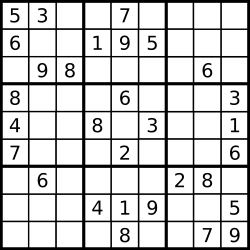

Cell (0, 0) - Avg Value: 62.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Cell (0, 1) - Avg Value: 60.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cell (0, 2) - Avg Value: 0.00
Cell (0, 3) - Avg Value: 0.00
Cell (0, 4) - Avg Value: 48.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (0, 5) - Avg Value: 0.00
Cell (0, 6) - Avg Value: 0.00
Cell (0, 7) - Avg Value: 0.00
Cell (0, 8) - Avg Value: 0.00
Cell (1, 0) - Avg Value: 67.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cell (1, 1) - Avg Value: 0.00
Cell (1, 2) - Avg Value: 0.00
Cell (1, 3) - Avg Value: 49.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Cell (1, 4) - Avg Value: 68.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cell (1, 5) - Avg Value: 64.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Cell (1, 6) - Avg Value: 0.00
Cell (1, 7) - Avg Value: 0.00
Cell (1, 8) - Avg Value: 0.00
Cell (2, 0) - Avg Value: 0.00
Cell (2, 1) - Avg Value: 69.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cell (2, 2) - Avg Value: 72.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (2, 3) - Avg V

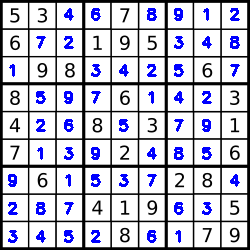

In [29]:
cv2_imshow(pipe('img.webp'))

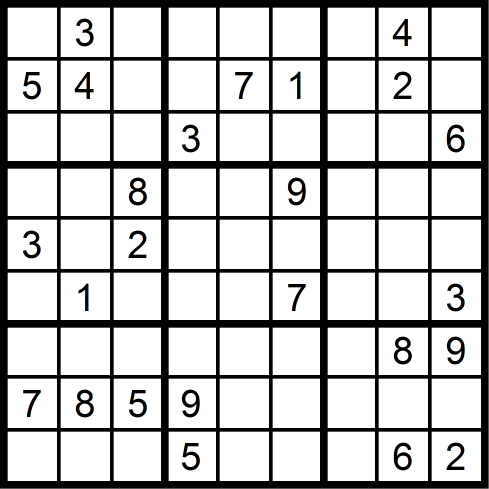

Cell (0, 0) - Avg Value: 0.00
Cell (0, 1) - Avg Value: 39.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (0, 2) - Avg Value: 0.00
Cell (0, 3) - Avg Value: 0.00
Cell (0, 4) - Avg Value: 0.00
Cell (0, 5) - Avg Value: 0.32
Cell (0, 6) - Avg Value: 3.11
Cell (0, 7) - Avg Value: 41.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Cell (0, 8) - Avg Value: 8.18
Cell (1, 0) - Avg Value: 42.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Cell (1, 1) - Avg Value: 36.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Cell (1, 2) - Avg Value: 0.00
Cell (1, 3) - Avg Value: 0.00
Cell (1, 4) - Avg Value: 29.16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cell (1, 5) - Avg Value: 24.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Cell (1, 6) - Avg Value: 0.01
Cell (1, 7) - Avg Value: 40.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Cell (1, 8) - Avg Value: 4.34
Cell (2, 0) - Avg Value: 0.00
Cell (2, 1) - Avg Value: 0.00
Cell (2, 2) - Avg Value: 0.00
Cell (2, 3) - Avg Value: 38.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Cell (2, 4) - Avg Value: 0.0

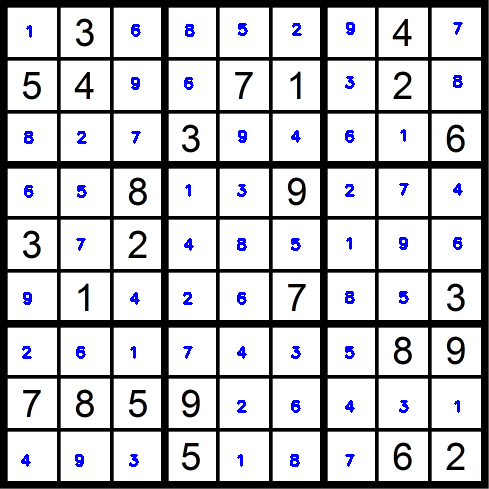

In [30]:
cv2_imshow(pipe('sudokupuzzle.png'))

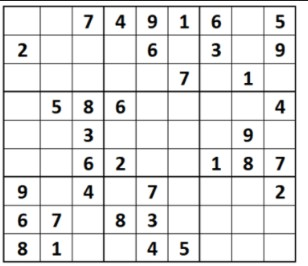

Cell (0, 0) - Avg Value: 0.00
Cell (0, 1) - Avg Value: 9.79
Cell (0, 2) - Avg Value: 47.17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Cell (0, 3) - Avg Value: 47.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (0, 4) - Avg Value: 51.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Cell (0, 5) - Avg Value: 43.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Cell (0, 6) - Avg Value: 52.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Cell (0, 7) - Avg Value: 0.00
Cell (0, 8) - Avg Value: 50.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Cell (1, 0) - Avg Value: 47.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Cell (1, 1) - Avg Value: 9.97
Cell (1, 2) - Avg Value: 3.87
Cell (1, 3) - Avg Value: 0.00
Cell (1, 4) - Avg Value: 54.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Cell (1, 5) - Avg Value: 0.00
Cell (1, 6) - Avg Value: 47.28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cell (1, 7) - Avg Value: 0.00
Cell (1, 8) - Avg Value: 54.14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Cell (2, 0) - Avg Value: 0.00
Cell (2, 1) - Avg Value: 9.11
Cell (2, 2

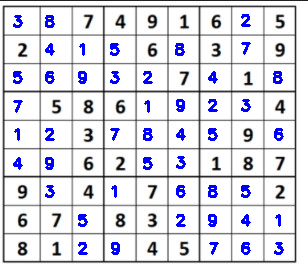

In [32]:
cv2_imshow(pipe('img3.jpg'))

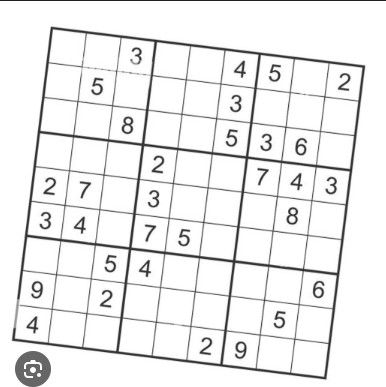

Cell (0, 0) - Avg Value: 0.00
Cell (0, 1) - Avg Value: 0.00
Cell (0, 2) - Avg Value: 48.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (0, 3) - Avg Value: 0.00
Cell (0, 4) - Avg Value: 0.00
Cell (0, 5) - Avg Value: 43.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cell (0, 6) - Avg Value: 52.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Cell (0, 7) - Avg Value: 0.00
Cell (0, 8) - Avg Value: 50.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (1, 0) - Avg Value: 0.00
Cell (1, 1) - Avg Value: 50.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Cell (1, 2) - Avg Value: 0.00
Cell (1, 3) - Avg Value: 0.00
Cell (1, 4) - Avg Value: 0.00
Cell (1, 5) - Avg Value: 49.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (1, 6) - Avg Value: 0.00
Cell (1, 7) - Avg Value: 0.00
Cell (1, 8) - Avg Value: 0.00
Cell (2, 0) - Avg Value: 0.00
Cell (2, 1) - Avg Value: 0.00
Cell (2, 2) - Avg Value: 57.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (2, 3) - Avg Value: 0.00
Cell (2, 4) - Avg Value: 0.00
Cell (2, 5) - Avg Value: 52.50
1/1 ━━

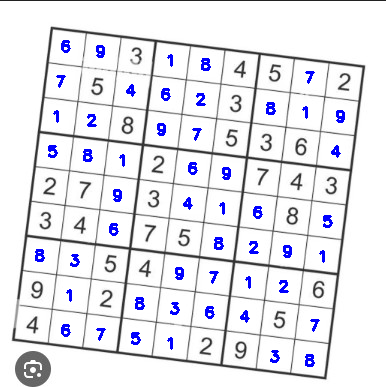

In [35]:
cv2_imshow(pipe('img6.jpg'))

#EXAMPLES WHERE ITS NOT WORKING

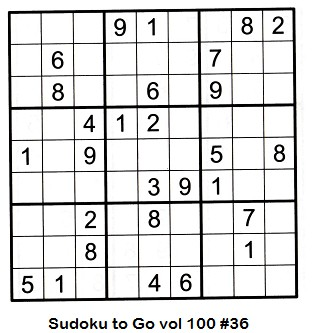

Cell (0, 0) - Avg Value: 0.00
Cell (0, 1) - Avg Value: 0.00
Cell (0, 2) - Avg Value: 0.00
Cell (0, 3) - Avg Value: 66.11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Cell (0, 4) - Avg Value: 35.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Cell (0, 5) - Avg Value: 0.87
Cell (0, 6) - Avg Value: 0.30
Cell (0, 7) - Avg Value: 67.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cell (0, 8) - Avg Value: 60.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Cell (1, 0) - Avg Value: 0.00
Cell (1, 1) - Avg Value: 67.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Cell (1, 2) - Avg Value: 0.00
Cell (1, 3) - Avg Value: 0.00
Cell (1, 4) - Avg Value: 0.00
Cell (1, 5) - Avg Value: 0.00
Cell (1, 6) - Avg Value: 45.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Cell (1, 7) - Avg Value: 0.00
Cell (1, 8) - Avg Value: 0.00
Cell (2, 0) - Avg Value: 0.97
Cell (2, 1) - Avg Value: 65.17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Cell (2, 2) - Avg Value: 0.00
Cell (2, 3) - Avg Value: 0.57
Cell (2, 4) - Avg Value: 65.02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/ste

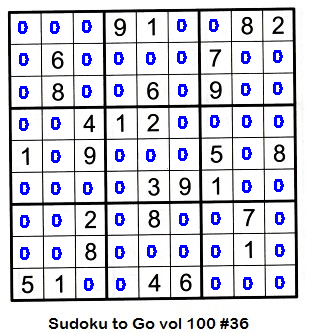

In [33]:
cv2_imshow(pipe('img4.jpg'))

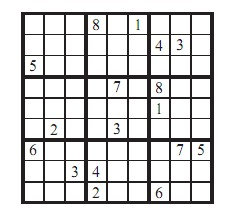

Cell (0, 0) - Avg Value: 3.37
Cell (0, 1) - Avg Value: 3.37
Cell (0, 2) - Avg Value: 3.37
Cell (0, 3) - Avg Value: 70.04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Cell (0, 4) - Avg Value: 3.37
Cell (0, 5) - Avg Value: 47.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Cell (0, 6) - Avg Value: 5.13
Cell (0, 7) - Avg Value: 8.17
Cell (0, 8) - Avg Value: 16.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Cell (1, 0) - Avg Value: 1.21
Cell (1, 1) - Avg Value: 1.32
Cell (1, 2) - Avg Value: 1.22
Cell (1, 3) - Avg Value: 1.22
Cell (1, 4) - Avg Value: 1.32
Cell (1, 5) - Avg Value: 1.19
Cell (1, 6) - Avg Value: 58.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Cell (1, 7) - Avg Value: 66.30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Cell (1, 8) - Avg Value: 14.21
Cell (2, 0) - Avg Value: 60.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Cell (2, 1) - Avg Value: 0.00
Cell (2, 2) - Avg Value: 0.00
Cell (2, 3) - Avg Value: 0.00
Cell (2, 4) - Avg Value: 0.00
Cell (2, 5) - Avg Value: 0.00
Cell (2, 6) - Avg Value: 1.76
Cell (2, 7) - A